We begin by importing the feffi package. Doing so will load all submodules, initialize the logging library (setting feffi log display level to `info` and fenics log display level to `debug`) and a default set of parameters. Look into `feffi/__init__.py` for more insight.

To see documentation for individual functions, run `help FUNCNAME` in a python shell (ex. `help feffi.parameters.define_parameters()`).

In [1]:
import feffi

The default set of parameters comes from `feffi.parameters.define_parameters()`, which by default loads the config file `config/square.yml`. The function `feffi.parameters.define_parameters()` accepts one optional argument consisting of a dictionary with key-valued settings. 

Some examples:
- `feffi.parameters.define_parameters()`: takes all values from config file `config/default.yml`.
- `feffi.parameters.define_parameters(
        user_config = {
            'config_file' : os.path.join('config', 'square.yml')
        }
    )
    `: takes values from config file `config/square.yml`.
- `feffi.parameters.define_parameters(
        user_config = {
            'config_file' : os.path.join('config', 'square.yml'),
            'final_time' : 24,
            'mesh_resolution : 30
        }
    )
    `: takes values from config file `config/square.yml` but replace `final_time` and `mesh_resolution` with specific values given.

Some remarks on parameters handling throughout the code:
- parameters are stored in a global variable called `config`. **Always access global configuration through something like:
`from . import parameters;`
`parameters.config`
- all feffi functions rely on the global config set up by `feffi.parameters.define_parameters`. However, per-function changes are possible. All functions accept \**kwargs.

It is possible to allow input of options from the terminal, which have higher priority with respect to config files and dictionary user provided config in the code. This can be achieved by adding a call to `feffi.parameters.parse_commandline_args()`. All config parameters can be tweaked from the terminal.

The next step is creating a mesh over the domain on which the simulation will run later.

In [4]:
mesh = feffi.mesh.create_mesh()

INFO:root:Initialized mesh: vertexes 121, max diameter 0.14


We then proceed to define the function spaces for velocity, pressure, temperature and salinity on the mesh. The solutions (and functions in all intermediate steps) will belong to these spaces.

In [5]:
f_spaces = feffi.functions.define_function_spaces(mesh)

In a similar fashion, we need to define the functions that will later be used in the variational formulations.

In [6]:
f = feffi.functions.define_functions(f_spaces)

By default (from FEniCS), all functions are initialized being zero on all mesh points.
An optional (but advised) step is to initialize them to a stable state drawn from the given config. This has the effect of speeding up convergence, since the simulation will start from a state that is closer to the solution.

In [7]:
feffi.functions.init_functions(f)

This will initialize functions in the following manner:
- pressure to hydrostatic: $\rho_0 g (1-y)$ (we use $1-y$ so that P = 0 at the top) WARNING:::: this creates problems if P is NOT set to 0 at some top point
- temperature to `T_0`
- salinity to `S_0`

(thinking about velocity to be init with BC applied)

We can now define the variational prolems to be solved. We use a modified version of Chorin's method, the so-called Incremental Pressure Correction Splitting (_IPCS_) scheme due to Goda (1979).

In [8]:
(stiffness_mats, load_vectors) = feffi.functions.define_variational_problems(f, mesh)

INFO:root:Defined variational problems


With the problems defined, we only need to specify what the boundaries are and which boundary conditions we would like to be enforced.

Boundaries are defined depending on whether the `domain` is `square` or `fjord`, and assigned an integer marker. The BCs that are applied are taken from the config, but can be tweaked by providing a dict as `BCs` parameter.

In [14]:
domain = feffi.boundaries.Domain(mesh, f_spaces)

INFO:root:BCs - Boundary right, space V[0] (marker 1), value 0.5*sin(2*pi*x[1])
INFO:root:BCs - Boundary right, space V[1] (marker 1), value 0
INFO:root:BCs - Boundary bottom, space V[0] (marker 2), value 0
INFO:root:BCs - Boundary bottom, space V[1] (marker 2), value 0
INFO:root:BCs - Boundary left, space V[0] (marker 3), value 0
INFO:root:BCs - Boundary left, space V[1] (marker 3), value 0
INFO:root:BCs - Boundary top, space V[0] (marker 4), value 0
INFO:root:BCs - Boundary top, space V[1] (marker 4), value 0
INFO:root:BCs - Boundary right, space T (marker 1), value 3
INFO:root:BCs - Boundary left, space T (marker 3), value -1.9
INFO:root:BCs - Boundary right, space S (marker 1), value 35
INFO:root:BCs - Boundary left, space S (marker 3), value 34.5
INFO:root:BCs - Top-right corner (1.000000, 1.000000), space Q, value 0


Then, we are finally ready to start the simulation (we'll set to only run up to 100 timestamps to showcase here).

In [19]:
simulation = feffi.simulation.Simulation(f, stiffness_mats, load_vectors, domain.BCs, max_iter = 100)

INFO:root:Initialized simulation


In [20]:
for i in range(5):
    simulation.timestep()

INFO:root:Timestep 0 of 100000: 
  ||u|| = 0.389, ||u||_8 = 0.816, ||u-u_n|| = 0.005, ||u-u_n||/||u|| = 0.012, 
  ||p|| = 5792092.742, ||p||_8 = 10032535.453, ||p-p_n|| = 2.624, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.295, ||T||_8 = 3.0, ||T-T_n|| = 0.009, ||T-T_n||/||T|| = 0.007, 
  ||S|| = 34.893, ||S||_8 = 35.114, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 1 of 100000: 
  ||u|| = 0.389, ||u||_8 = 0.817, ||u-u_n|| = 0.005, ||u-u_n||/||u|| = 0.012, 
  ||p|| = 5792092.512, ||p||_8 = 10032535.102, ||p-p_n|| = 2.618, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.295, ||T||_8 = 3.0, ||T-T_n|| = 0.009, ||T-T_n||/||T|| = 0.007, 
  ||S|| = 34.893, ||S||_8 = 35.114, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 2 of 100000: 
  ||u|| = 0.389, ||u||_8 = 0.817, ||u-u_n|| = 0.005, ||u-u_n||/||u|| = 0.012, 
  ||p|| = 5792092.282, ||p||_8 = 10032534.751, ||p-p_n|| = 2.62, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.295, ||T||_8 = 3.0, ||T-T_n|| = 0.009, ||T-T_n||/||T|| = 0.007, 
  

`simulation.timestep()` allows to progress the simulation by one timestep, but it can also be let run freely until convergence (or until desired precision is reached)

In [21]:
simulation.run()

INFO:root:Running full simulation; started at 2020-10-19 11:55:47.857334 
INFO:root:Timestep 5 of 100000: 
  ||u|| = 0.389, ||u||_8 = 0.819, ||u-u_n|| = 0.005, ||u-u_n||/||u|| = 0.012, 
  ||p|| = 5792091.591, ||p||_8 = 10032533.698, ||p-p_n|| = 2.617, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.296, ||T||_8 = 3.0, ||T-T_n|| = 0.009, ||T-T_n||/||T|| = 0.007, 
  ||S|| = 34.893, ||S||_8 = 35.114, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 6 of 100000: 
  ||u|| = 0.39, ||u||_8 = 0.819, ||u-u_n|| = 0.005, ||u-u_n||/||u|| = 0.012, 
  ||p|| = 5792091.361, ||p||_8 = 10032533.347, ||p-p_n|| = 2.614, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.297, ||T||_8 = 3.0, ||T-T_n|| = 0.009, ||T-T_n||/||T|| = 0.007, 
  ||S|| = 34.893, ||S||_8 = 35.114, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 7 of 100000: 
  ||u|| = 0.39, ||u||_8 = 0.82, ||u-u_n|| = 0.005, ||u-u_n||/||u|| = 0.012, 
  ||p|| = 5792091.131, ||p||_8 = 10032532.996, ||p-p_n|| = 2.611, ||p-p_n||/||p|| = 0.0, 
  ||T||

INFO:root:Timestep 28 of 100000: 
  ||u|| = 0.393, ||u||_8 = 0.831, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.011, 
  ||p|| = 5792086.359, ||p||_8 = 10032525.681, ||p-p_n|| = 2.558, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.303, ||T||_8 = 3.0, ||T-T_n|| = 0.009, ||T-T_n||/||T|| = 0.007, 
  ||S|| = 34.892, ||S||_8 = 35.114, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 29 of 100000: 
  ||u|| = 0.393, ||u||_8 = 0.831, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.011, 
  ||p|| = 5792086.134, ||p||_8 = 10032525.335, ||p-p_n|| = 2.555, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.303, ||T||_8 = 3.0, ||T-T_n|| = 0.009, ||T-T_n||/||T|| = 0.007, 
  ||S|| = 34.891, ||S||_8 = 35.114, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 30 of 100000: 
  ||u|| = 0.393, ||u||_8 = 0.832, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.011, 
  ||p|| = 5792085.91, ||p||_8 = 10032524.989, ||p-p_n|| = 2.553, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.303, ||T||_8 = 3.0, ||T-T_n|| = 0.009, ||T-T_n||/||T|| = 0.007, 

INFO:root:Timestep 51 of 100000: 
  ||u|| = 0.397, ||u||_8 = 0.842, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.011, 
  ||p|| = 5792081.244, ||p||_8 = 10032517.769, ||p-p_n|| = 2.502, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.309, ||T||_8 = 3.0, ||T-T_n|| = 0.009, ||T-T_n||/||T|| = 0.007, 
  ||S|| = 34.89, ||S||_8 = 35.114, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 52 of 100000: 
  ||u|| = 0.397, ||u||_8 = 0.843, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.011, 
  ||p|| = 5792081.024, ||p||_8 = 10032517.427, ||p-p_n|| = 2.5, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.309, ||T||_8 = 3.0, ||T-T_n|| = 0.009, ||T-T_n||/||T|| = 0.007, 
  ||S|| = 34.89, ||S||_8 = 35.114, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 53 of 100000: 
  ||u|| = 0.397, ||u||_8 = 0.843, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.011, 
  ||p|| = 5792080.804, ||p||_8 = 10032517.085, ||p-p_n|| = 2.498, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.31, ||T||_8 = 3.0, ||T-T_n|| = 0.009, ||T-T_n||/||T|| = 0.007, 
  |

INFO:root:Timestep 74 of 100000: 
  ||u|| = 0.4, ||u||_8 = 0.853, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.011, 
  ||p|| = 5792076.239, ||p||_8 = 10032509.956, ||p-p_n|| = 2.449, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.315, ||T||_8 = 3.0, ||T-T_n|| = 0.008, ||T-T_n||/||T|| = 0.006, 
  ||S|| = 34.889, ||S||_8 = 35.114, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 75 of 100000: 
  ||u|| = 0.4, ||u||_8 = 0.854, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.011, 
  ||p|| = 5792076.024, ||p||_8 = 10032509.618, ||p-p_n|| = 2.447, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.315, ||T||_8 = 3.0, ||T-T_n|| = 0.008, ||T-T_n||/||T|| = 0.006, 
  ||S|| = 34.889, ||S||_8 = 35.114, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 76 of 100000: 
  ||u|| = 0.4, ||u||_8 = 0.854, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.011, 
  ||p|| = 5792075.809, ||p||_8 = 10032509.281, ||p-p_n|| = 2.445, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.316, ||T||_8 = 3.0, ||T-T_n|| = 0.008, ||T-T_n||/||T|| = 0.006, 
  ||

INFO:root:Timestep 97 of 100000: 
  ||u|| = 0.403, ||u||_8 = 0.864, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.01, 
  ||p|| = 5792071.341, ||p||_8 = 10032502.236, ||p-p_n|| = 2.399, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.321, ||T||_8 = 3.0, ||T-T_n|| = 0.008, ||T-T_n||/||T|| = 0.006, 
  ||S|| = 34.888, ||S||_8 = 35.115, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 98 of 100000: 
  ||u|| = 0.403, ||u||_8 = 0.864, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.01, 
  ||p|| = 5792071.13, ||p||_8 = 10032501.903, ||p-p_n|| = 2.396, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.321, ||T||_8 = 3.0, ||T-T_n|| = 0.008, ||T-T_n||/||T|| = 0.006, 
  ||S|| = 34.888, ||S||_8 = 35.115, ||S - S_n|| = 0.001, ||S - S_n||/||S|| = 0.0
INFO:root:Timestep 99 of 100000: 
  ||u|| = 0.404, ||u||_8 = 0.865, ||u-u_n|| = 0.004, ||u-u_n||/||u|| = 0.01, 
  ||p|| = 5792070.92, ||p||_8 = 10032501.569, ||p-p_n|| = 2.394, ||p-p_n||/||p|| = 0.0, 
  ||T|| = 1.322, ||T||_8 = 3.0, ||T-T_n|| = 0.008, ||T-T_n||/||T|| = 0.006, 
  |

Mesh and solutions for all variables can then be plotted:

INFO:root:Plotting Mesh...


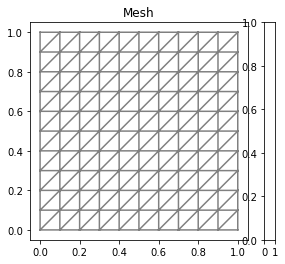

INFO:root:Plotting Velocity...


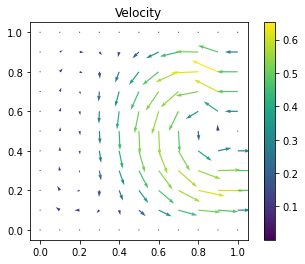

INFO:root:Plotting Pressure...


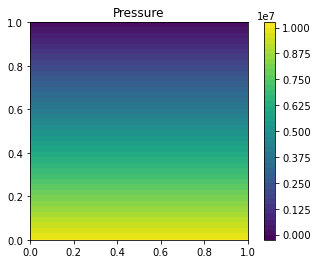

INFO:root:Plotting Temperature...


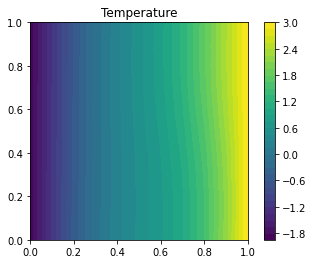

In [23]:
feffi.plot.plot_single(mesh, file_name = 'mesh.png', title = 'Mesh', display = True)
feffi.plot.plot_solutions(f, display = True)